<h1 style="color: white; background-color: green;">Wikipedia Text Processing and Visualization
</h1>

<h2 style="color: white; background-color: green;">Business Problem</h2>

Perform text preprocessing and visualization on a dataset containing Wikipedia texts.

<h2 style="color: white; background-color: green;">Required Libraries</h2>

In [36]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from surprise.model_selection import train_test_split
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

<h2 style="color: white; background-color: green;">Text Preprocessing</h2>

In [37]:
df = pd.read_csv("NLP/datasets/wiki_data.csv")
df.head()

,Unnamed: 0,text
0,1,Anovo\n\nAnovo (formerly A Novo) is a computer...
1,2,Battery indicator\n\nA battery indicator (also...
2,3,"Bob Pease\n\nRobert Allen Pease (August 22, 19..."
3,4,CAVNET\n\nCAVNET was a secure military forum w...
4,5,CLidar\n\nThe CLidar is a scientific instrumen...


In [38]:
df.shape

(10859, 2)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10859 entries, 0 to 10858
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10859 non-null  int64 
 1   text        10859 non-null  object
dtypes: int64(1), object(1)
memory usage: 169.8+ KB


<h3 style="color: white; background-color: green;">Normalizing Case Folding, Removing Numerical Values and Punctuation</h3>

In [40]:
import re

def clean_text(text):
    """
    Text Preprocessing Function:

    Convert text to lowercase/uppercase
    Remove punctuation marks
    Remove numbers
    """
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation marks
    return text

df["cleaned_text"] = df["text"].apply(clean_text)

df[["text", "cleaned_text"]].head()

,text,cleaned_text
0,Anovo\n\nAnovo (formerly A Novo) is a computer...,anovo\n\nanovo formerly a novo is a computer s...
1,Battery indicator\n\nA battery indicator (also...,battery indicator\n\na battery indicator also ...
2,"Bob Pease\n\nRobert Allen Pease (August 22, 19...",bob pease\n\nrobert allen pease august â â ju...
3,CAVNET\n\nCAVNET was a secure military forum w...,cavnet\n\ncavnet was a secure military forum w...
4,CLidar\n\nThe CLidar is a scientific instrumen...,clidar\n\nthe clidar is a scientific instrumen...


<h3 style="color: white; background-color: green;">Removing Stopwords</h3>

In [41]:
sw = stopwords.words('english')

In [42]:
# Write a function to remove stopwords from the text
def remove_stopwords(text):
    """
    The function that removes words containing stopwords from the text.
    """
    words = text.split()  # Split the text into words
    filtered_words = [word for word in words if word not in sw]  # Keep only the words that are not stopwords
    return " ".join(filtered_words)  # Join the words back together

# Apply the function to the dataset
df["cleaned_text_no_stopwords"] = df["cleaned_text"].apply(remove_stopwords)

df[["cleaned_text", "cleaned_text_no_stopwords"]].head()

,cleaned_text,cleaned_text_no_stopwords
0,anovo\n\nanovo formerly a novo is a computer s...,anovo anovo formerly novo computer services co...
1,battery indicator\n\na battery indicator also ...,battery indicator battery indicator also known...
2,bob pease\n\nrobert allen pease august â â ju...,bob pease robert allen pease august â â june a...
3,cavnet\n\ncavnet was a secure military forum w...,cavnet cavnet secure military forum became ope...
4,clidar\n\nthe clidar is a scientific instrumen...,clidar clidar scientific instrument used measu...


<h3 style="color: white; background-color: green;">Removing Rarewords</h3>

In [43]:
from collections import Counter

# Combine all texts and calculate word frequencies
all_words = " ".join(df["cleaned_text_no_stopwords"]).split()
word_counts = Counter(all_words)

word_counts.most_common(10)

[('used', 29403),
 ('also', 22951),
 ('use', 16820),
 ('one', 15929),
 ('â', 15769),
 ('system', 15522),
 ('first', 15284),
 ('may', 13555),
 ('systems', 11351),
 ('new', 11322)]

In [44]:
rare_words = {word for word, count in word_counts.items() if count < 1000}

In [45]:
def remove_rare_words(text, rare_words):
    return " ".join([word for word in text.split() if word not in rare_words])

df["cleaned_text_no_rare_words"] = df["cleaned_text_no_stopwords"].apply(lambda x: remove_rare_words(x, rare_words))

df[["cleaned_text_no_stopwords", "cleaned_text_no_rare_words"]].head()

,cleaned_text_no_stopwords,cleaned_text_no_rare_words
0,anovo anovo formerly novo computer services co...,computer services company based france founded...
1,battery indicator battery indicator also known...,battery battery also known battery device info...
2,bob pease robert allen pease august â â june a...,august â â june analog integrated circuit desi...
3,cavnet cavnet secure military forum became ope...,military became april part allows access knowl...
4,clidar clidar scientific instrument used measu...,scientific instrument used lower camera turn l...


<h3 style="color: white; background-color: green;">Tokenization</h3>


In [46]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download("punkt")

def tokenize_text(text):
    return word_tokenize(text)

df["tokenized_text"] = df["cleaned_text_no_rare_words"].apply(tokenize_text)

df[["cleaned_text_no_rare_words", "tokenized_text"]].head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gozdekizilkaya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,cleaned_text_no_rare_words,tokenized_text
0,computer services company based france founded...,"[computer, services, company, based, france, f..."
1,battery battery also known battery device info...,"[battery, battery, also, known, battery, devic..."
2,august â â june analog integrated circuit desi...,"[august, â, â, june, analog, integrated, circu..."
3,military became april part allows access knowl...,"[military, became, april, part, allows, access..."
4,scientific instrument used lower camera turn l...,"[scientific, instrument, used, lower, camera, ..."


<h3 style="color: white; background-color: green;">Lemmatization</h3>

In [47]:
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df["lemmatized_text"] = df["tokenized_text"].apply(lemmatize_tokens)

df[["tokenized_text", "lemmatized_text"]].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gozdekizilkaya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gozdekizilkaya/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,tokenized_text,lemmatized_text
0,"[computer, services, company, based, france, f...","[computer, service, company, based, france, fo..."
1,"[battery, battery, also, known, battery, devic...","[battery, battery, also, known, battery, devic..."
2,"[august, â, â, june, analog, integrated, circu...","[august, â, â, june, analog, integrated, circu..."
3,"[military, became, april, part, allows, access...","[military, became, april, part, allows, access..."
4,"[scientific, instrument, used, lower, camera, ...","[scientific, instrument, used, lower, camera, ..."


<h2 style="color: white; background-color: green;">Text Visualization</h2>

<h3 style="color: white; background-color: green;">Calculation of Term Frequencies</h3>

In [48]:
from collections import Counter

# Combine all lemmatized words and calculate their frequencies
all_lemmatized_words = [word for tokens in df["lemmatized_text"] for word in tokens]
word_freq = Counter(all_lemmatized_words)

word_freq.most_common(20)

[('used', 29403),
 ('system', 26873),
 ('also', 22951),
 ('use', 16820),
 ('one', 15929),
 ('â', 15769),
 ('first', 15284),
 ('company', 13806),
 ('may', 13555),
 ('time', 12703),
 ('technology', 12325),
 ('new', 11322),
 ('design', 11262),
 ('two', 10909),
 ('using', 9842),
 ('many', 9679),
 ('device', 9482),
 ('would', 9430),
 ('product', 9254),
 ('state', 8884)]

<h3 style="color: white; background-color: green;">Barplot</h3>

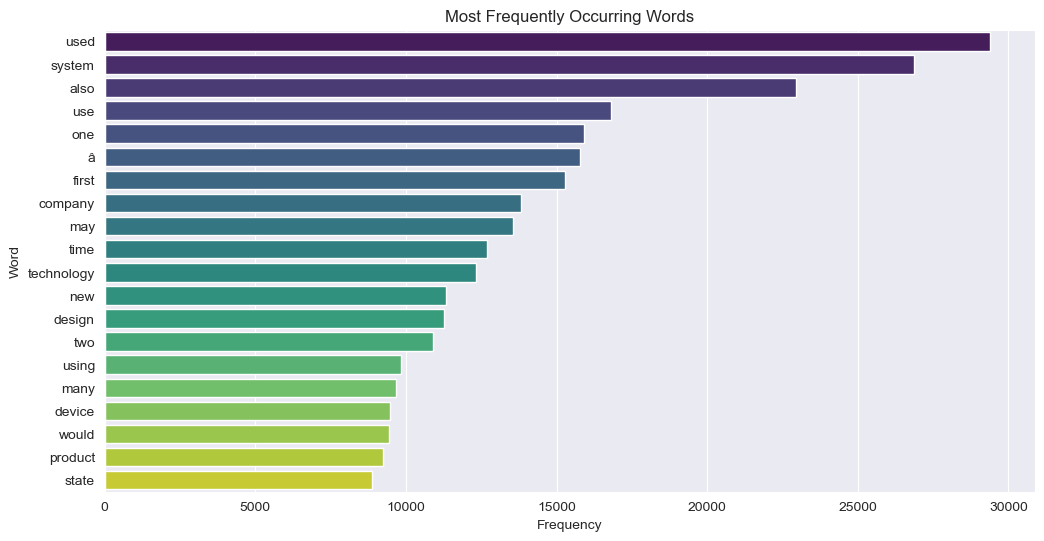

In [49]:
# Select the 20 common words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Most Frequently Occurring Words")
plt.show()

<h3 style="color: white; background-color: green;">Wordcloud</h3>

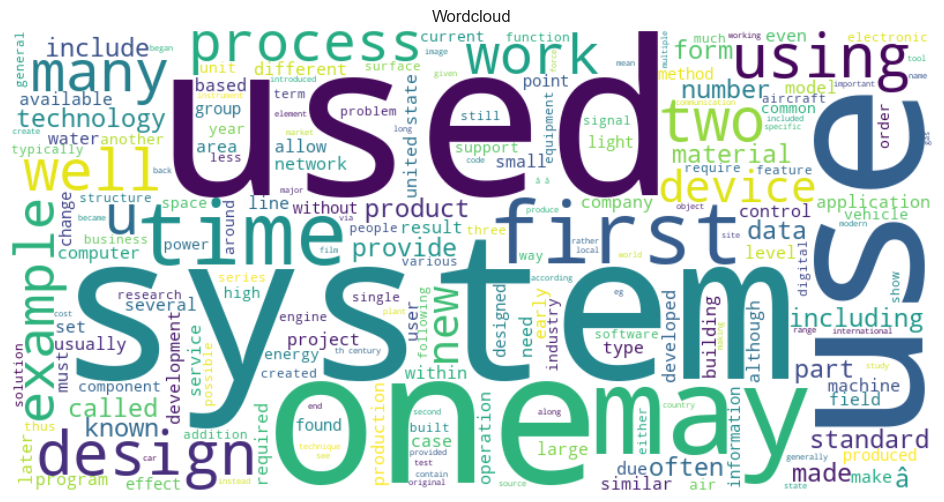

In [50]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_lemmatized_words))

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud")
plt.show()

<h2 style="color: white; background-color: green;">Refactoring the Entire Process into Functions</h2>


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gozdekizilkaya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gozdekizilkaya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gozdekizilkaya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gozdekizilkaya/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


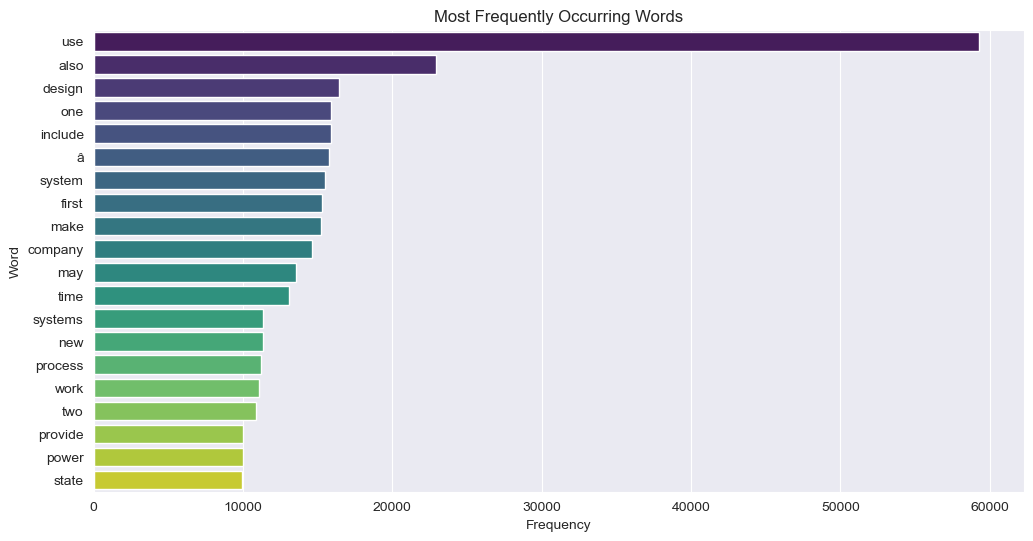

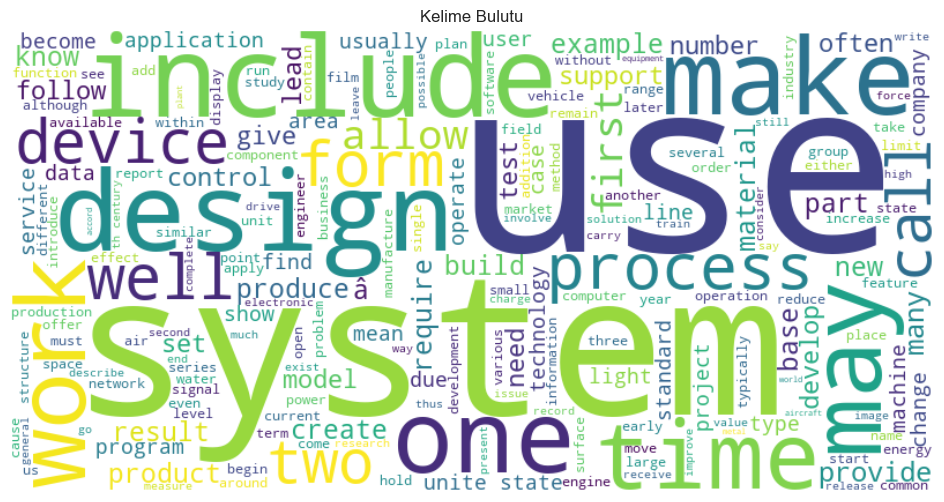

,text,processed_text
0,Anovo\n\nAnovo (formerly A Novo) is a computer...,computer service company base france found go ...
1,Battery indicator\n\nA battery indicator (also...,battery battery also know battery device give ...
2,"Bob Pease\n\nRobert Allen Pease (August 22, 19...",august â â june analog integrate circuit desig...
3,CAVNET\n\nCAVNET was a secure military forum w...,military become april part allow access knowle...
4,CLidar\n\nThe CLidar is a scientific instrumen...,scientific instrument use measure lower stand ...


In [51]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Download the necessary NLTK components
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Retrieve the stopwords list
from nltk.corpus import stopwords
sw = set(stopwords.words('english'))  # Using a set improves processing speed

def preprocess_and_visualize(texts, remove_rare_threshold=1000):
    """
    Processes text, performs frequency analysis, and visualizes the results.

    Steps:
    Convert text to lowercase/uppercase
    Remove punctuation and numbers
    Remove stopwords
    Tokenization
    Lemmatization (with POS tagging for verbs)
    Remove rare words
    Perform frequency analysis and visualization (Barplot, WordCloud)
    Parameters:
    texts: A list of texts
    remove_rare_threshold: Threshold for rare words (Default: 1000)

    """
    lemmatizer = WordNetLemmatizer()

    # Text cleaning
    def clean_text(text):
        text = str(text).lower()  # Convert to string to prevent NaN or float values
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation marks
        return text

    # Stopwords removal
    def remove_stopwords(text):
        words = text.split()
        return " ".join([word for word in words if word not in sw])

    # Tokenization and lemmatization
    def tokenize_and_lemmatize(text):
        tokens = word_tokenize(text)
        return [lemmatizer.lemmatize(token, pos="v") for token in tokens]  # Lemmatize as a verb

    # Apply the processes to the texts
    texts = [clean_text(text) for text in texts]
    texts = [remove_stopwords(text) for text in texts]
    tokenized_texts = [tokenize_and_lemmatize(text) for text in texts]

    # Remove rare words
    all_words = [word for tokens in tokenized_texts for word in tokens]
    word_freq = Counter(all_words)
    rare_words = {word for word, count in word_freq.items() if count < remove_rare_threshold}

    def remove_rare_words(tokens):
        return [word for word in tokens if word not in rare_words]

    final_texts = [remove_rare_words(tokens) for tokens in tokenized_texts]

    # Frequency analysis and visualization
    word_freq = Counter([word for tokens in final_texts for word in tokens if word.strip() != ""])  # Remove empty words

   # Visualize the 20 most common words
    common_words = word_freq.most_common(20)
    words, counts = zip(*common_words)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.title("Most Frequently Occurring Words")
    plt.show()

    #  WordCloud visualization
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(word for tokens in final_texts for word in tokens))

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Kelime Bulutu")
    plt.show()

    return final_texts

# Apply the function to the dataset
processed_texts = preprocess_and_visualize(df["text"].dropna().tolist())  # Send after cleaning NaN values

df["processed_text"] = [" ".join(text) for text in processed_texts]

# View the result
df[["text", "processed_text"]].head()
